<a href="https://colab.research.google.com/github/andresnigenda/cpd_complaints_nlp/blob/master/src/supervised/Naive_Bayes_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import packages and libraries
import numpy as np
import random as rnd
import re
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics
from sklearn.utils import Bunch
from sklearn.feature_extraction import text 

from time import time
from pprint import pprint
from copy import deepcopy
from wordcloud import WordCloud 
from  Semi_EM_NB import Semi_EM_MultinomialNB
from os import path
from PIL import Image

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Functions

Functions below are drawn from https://github.com/jerry-shijieli/Text_Classification_Using_EM_And_Semisupervied_Learning

In [0]:
def remove_noise(sentence):
    result = ''
    poster = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    sentence = sentence.decode('utf8')
    wordlist = re.sub(r"\n|(\\(.*?){)|}|[!$%^&*#()_+|~\-={}\[\]:\";'<>?,.\/\\]|[0-9]|[@]", ' ', sentence) # remove punctuation
    wordlist = re.sub('\s+', ' ', wordlist) # remove extra space
    wordlist_normal = [poster.stem(word.lower()) for word in wordlist.split()] # restore word to its original form (stemming)
    wordlist_normal = [lemmatizer.lemmatize(word, pos='v') for word in wordlist_normal] # restore word to its root form (lemmatization)
    wordlist_clean = [word for word in wordlist_normal if word not in stopword_set] # remove stopwords
    result = ' '.join(wordlist_clean)
    return result

In [0]:
def cross_validation(clf, data_X, data_y, unlabeled=None, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_accuracies= list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==None:
            cv_clf.fit(train_X, train_y)
        else:
            cv_clf.fit(train_X, train_y, unlabeled)
        pred = cv_clf.predict(valid_X)
        train_accuracies.append(metrics.accuracy_score(valid_y, pred))
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % np.mean(np.array(train_accuracies)))
    return train_accuracies, train_time

In [0]:
def show_topK(classifier, vectorizer, categories, K=5):
    feature_names = np.asarray(vectorizer.get_feature_names())
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(figsize=(50, 40), nrows=nrows, ncols=ncols)
    circle_mask = np.array(Image.open(path.join('circle.png')))
    for i, category in enumerate(categories):
        topK = np.argsort(classifier.coef_[i])[-K:]
        text = " ".join(feature_names[topK])
        print("%s: %s" % (category, text))
        wordcloud = WordCloud(background_color="white", mask=circle_mask).generate(text)
        axes[i//ncols, i%ncols].imshow(wordcloud, cmap=plt.cm.cool_r, interpolation='bilinear')
        axes[i//ncols, i%ncols].axis("off")
        axes[i//ncols, i%ncols].set_title(category, fontweight="bold", size=24)
    plt.show()



## Clean labelled data

In [0]:
import pandas as pd
all_text = pd.read_csv("training_with_text.csv")
text_filled = all_text.loc[pd.notna(all_text.text_content)]

In [0]:
def clean_text(row):
  no_n = row['text_content'].replace('\n', ' ')
  no_special = re.sub("[^a-zA-Z0-9]+", ' ', no_n)
  return re.sub('\d', ' ', no_special)
text_filled['text_content'] = text_filled.apply(lambda x: clean_text(x), axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [0]:
  target_names_lst = [u'nudity_penetration',
  u'sexual_relations_with_a_minor_', u'sexual_harassment_sexual_remarks',
  u'domestic_violence_police_committing_',
  u'sexual_humiliation_sexual_extortion_prostitution_sex_work',
  u'tasers_baton_aggressive_physical_touch_gun', u'trespass_robbery',
  u'biometric_surveillance_fitting_a_description_gang_related_',
  u'racial_slurs_xenophobic_remarks_',
  u'undocumented_status_asking_for_someone_s_status_calling_ice_',
  u'planting_drug_guns', u'neglect_of_duty_failure_to_serve',
  u'refusing_to_provide_medical_assistance', u'workplace_harassment',
  u'_irrational_aggressive_unstable_', u'suicide_in_jail_improper_care_',
  u'dcfs_threats', u'pregnant_women', u'school',
  u'searching_patting_down_arresting_minors']

In [0]:
for category in target_names_lst:
  if text_filled[category].sum() < 2:
    print(category)
    text_filled.drop(columns=category, inplace=True)
    target_names_lst.remove(category)
text_filled.head()

sexual_relations_with_a_minor_
undocumented_status_asking_for_someone_s_status_calling_ice_
workplace_harassment
suicide_in_jail_improper_care_
pregnant_women


,_allegation_id,title,url,text_bad,incident_date,category,allegation_name,tag,nudity_penetration,sexual_harassment_sexual_remarks,domestic_violence_police_committing_,sexual_humiliation_sexual_extortion_prostitution_sex_work,tasers_baton_aggressive_physical_touch_gun,trespass_robbery,biometric_surveillance_fitting_a_description_gang_related_,racial_slurs_xenophobic_remarks_,planting_drug_guns,neglect_of_duty_failure_to_serve,refusing_to_provide_medical_assistance,_irrational_aggressive_unstable_,dcfs_threats,school,searching_patting_down_arresting_minors,allegation_id,title.1,text_content,incident_date.1,most_common_category_id,category.1,allegation_name.1,coaccused_count,tag.1,source_type
0,297735,CRID 297735 CR,https://assets.documentcloud.org/documents/457...,NaN,2004-04-29T00:00:00Z,Use Of Force,Unnecessary Physical Contact / On Duty - No In...,CR,0,0,0,0,1,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,297735,CRID 297735 CPB,BEFORE THE POLICE BOARD OF THE CITY OF CHICAGO...,2004-04-29T00:00:00Z,109,Use Of Force,Unnecessary Physical Contact / On Duty - No In...,3,CPB,DOCUMENTCLOUD
1,300059,CRID 300059 CR,https://assets.documentcloud.org/documents/476...,NaN,2004-07-17T00:00:00Z,Lockup Procedures,Prisoners Property,CR,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300059,CRID 300059 CR,SUMMARY REPORT DIGEST DATE OF REPORT COMPLAINT...,2004-07-17T00:00:00Z,92,Lockup Procedures,Prisoners Property,1,CR,DOCUMENTCLOUD
2,1089005,CRID 1089005 CR COPA Summary Report,https://assets.documentcloud.org/documents/576...,NaN,2018-03-01T00:00:00Z,Use Of Force,Coercion - Threat Of Arrest/Charges,CR,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1089005,CRID 1089005 CR COPA Summary Report,CIVILIAN OFFICE OF POLICE ACCOUNTABILITY ...,2018-03-01T00:00:00Z,248,Use Of Force,Coercion - Threat Of Arrest/Charges,2,CR,SUMMARY_REPORTS_COPA_DOCUMENTCLOUD
3,299023,CRID 299023 CR,https://assets.documentcloud.org/documents/476...,NaN,2004-06-18T00:00:00Z,Use Of Force,Excessive Force / On Duty - Injury,CR,0,0,0,0,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,299023,CRID 299023 CR,OFFICE OF PROFESSIONAL STANDARDS W th Str...,2004-06-18T00:00:00Z,98,Use Of Force,Excessive Force / On Duty - Injury,1,CR,DOCUMENTCLOUD
4,313007,CRID 313007 CR,https://assets.documentcloud.org/documents/325...,1.0,2006-05-14T00:00:00Z,Illegal Search,Search Of Premise Without Warrant,CR,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,313007,CRID 313007 CR,IUMMARY REPORT SOMPLAINT REGISTER INVESTIGATIO...,2006-05-14T00:00:00Z,71,Illegal Search,Search Of Premise Without Warrant,1,CR,DOCUMENTCLOUD


In [0]:
label_index = {label: index for (index, label) in enumerate(target_names_lst)}

In [0]:
def build_target(row):
  rnd.seed(a=2)
  marked_labels = []
  for label in row[target_names_lst].index:
    if row[label] == 1:
      marked_labels.append(label)
  if len(marked_labels) >= 1:
    chosen = rnd.choice(marked_labels)
    return int(label_index[chosen])
  else:
    return None

text_filled['target_vals'] = text_filled.apply(build_target, axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [0]:
text_filled = text_filled.loc[pd.notna(text_filled.target_vals)]

In [0]:
data_Xy = Bunch(data = list(text_filled.text_content), 
                  target = np.array(text_filled.target_vals),
                  target_names = target_names_lst)

## Clean unlabelled data

In [0]:
all_unlabeled = pd.read_csv("narratives.csv")

In [0]:
all_unlabeled['text'].iloc[15]

'The Reporting Party Victim alleges that he\nwas "bumped" off of his bike by unknown\nofficers driving in an unmarked squad car\nThe Reporting Party Victim further alleges\nthat one of the unknown officers slammed\nhis face against the wall.'

In [0]:
#Drop text <= 50 characters
all_unlabeled = all_unlabeled.loc[all_unlabeled.apply(lambda x: len(x['text']) > 50, axis=1)]

In [0]:
all_unlabeled.iloc[0].text

'The reporting party alleges that the\naccused officer was rude and\nunprofessional during a traffic stop, the\naccused officer threatened to place her in\nhandcuffs and failed to inform the\ncomplainant as to why she was being\nstopped.\nThe reporting party further alleges that the\nofficer stated,"License and registration now\nbefore | snatch you out of this car and put\nyou in handcuffs."'

In [0]:
unlabeled_lst = list(all_unlabeled.text)

In [0]:
unlabeled_lst_clean = map(remove_noise, unlabeled_lst)

## Run Models

In [0]:
# Load data set with class labels and split into train and test set
test_size_ratio = 0.2
# data_Xy = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
category_names = data_Xy.target_names # text names of all categories
train_X, test_X, train_y, test_y = train_test_split(data_Xy.data, data_Xy.target, test_size=test_size_ratio, stratify=data_Xy.target, random_state=8)
print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))

Training set size:      180	Test set size:       45


In [0]:
# preprocess train and test text data
train_X_clean = map(remove_noise, train_X)
test_X_clean = map(remove_noise, test_X)

In [0]:
#Add stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(["accused", "reporting", "party", "alleges", "officer", 
                        "alleged", "alleges", "chicago", "civilian", "complainant", "officers", "victim", 
                        "police", "stated", "report", "states", "called", 
                        "did", "told", "provide", "incid", "incident", "regarding", "issued",
                        "reported", "vehicle", "car", "complaint", "justification",
                        "district", "uniformed", "threatened", "witness", "th",
                        "number", "scene"])

In [0]:
# Convert all text data into tf-idf vectors 
vectorizer = TfidfVectorizer(stop_words=my_stop_words, min_df=5, max_df=0.95)
# vectorizer = TfidfVectorizer()
train_vec = vectorizer.fit_transform(train_X_clean)
test_vec = vectorizer.transform(test_X_clean)
unlabeled_vec = vectorizer.transform(unlabeled_lst_clean)
print train_vec.shape, test_vec.shape, unlabeled_vec.shape

(180, 3979) (45, 3979) (19888, 3979)


In [0]:
# Divide train data set into labeled and unlabeled data sets
split_ratio = 0.2
#X_l = train_vec
#y_l = train_y
#X_u = unlabeled_vec
X_u, X_l, y_u, y_l = train_test_split(train_vec, train_y, train_size=split_ratio, stratify=train_y, random_state=2)
print X_l.shape, X_u.shape

(144, 3979) (36, 3979)


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [0]:
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_clf = MultinomialNB(alpha=1e-2)
cross_validation(nb_clf, X_l, y_l)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.039 seconds
Average training accuracy: 0.484


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


([0.4411764705882353, 0.46875, 0.39285714285714285, 0.6153846153846154, 0.5],
 0.03859901428222656)

In [0]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False) # semi supervised EM based Naive Bayes classifier
cross_validation(em_nb_clf, X_l, y_l, X_u)

Validation: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.183 seconds
Average training accuracy: 0.478


([0.4411764705882353, 0.40625, 0.42857142857142855, 0.6153846153846154, 0.5],
 0.18253588676452637)

In [0]:
# Evaluate original NB classifier using test data set
nb_clf = MultinomialNB(alpha=1e-2).fit(X_l, y_l)
pred = nb_clf.predict(test_vec)
#print(metrics.classification_report(test_y, pred, target_names=category_names))
# pprint(metrics.confusion_matrix(test_Xy.target, pred))
print(metrics.accuracy_score(test_y, pred))

0.7111111111111111


In [0]:
# Evaluate semi-supervised EM NB classifier using test data set
em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False).fit(X_l, y_l, X_u)
pred = em_nb_clf.predict(test_vec)
#print(metrics.classification_report(test_y, pred, target_names=category_names))
# pprint(metrics.confusion_matrix(test_Xy.target, pred))
print(metrics.accuracy_score(test_y, pred))

0.6444444444444445


nudity_penetration: exchang os attach affidavit grand ask enforc copa vehicl appoint complain februari search strip subject
sexual_harassment_sexual_remarks: letter ed alter copi igat medlcal injur game sexual noti attach certi page cer complain
domestic_violence_police_committing_: hear therebi illinoi johnson abus school child dcf decis hi board respond award involv moham
sexual_humiliation_sexual_extortion_prostitution_sex_work: subject mother purs sex charg sexual decis richmond respond cer johnna hear carey award board
tasers_baton_aggressive_physical_touch_gun: treaci page duti watt time injur arrest complain profession attach standard recommend sustain hi cer
trespass_robbery: cer assign right request form hear recommend time examin interrog advis counsel sgt complain attach
biometric_surveillance_fitting_a_description_gang_related_: restaur judg becaus taco offcer say hi videotap walsh delay testifi plaintiff testimoni murphi board
racial_slurs_xenophobic_remarks_: piwnicki rec

IndexError: ignored

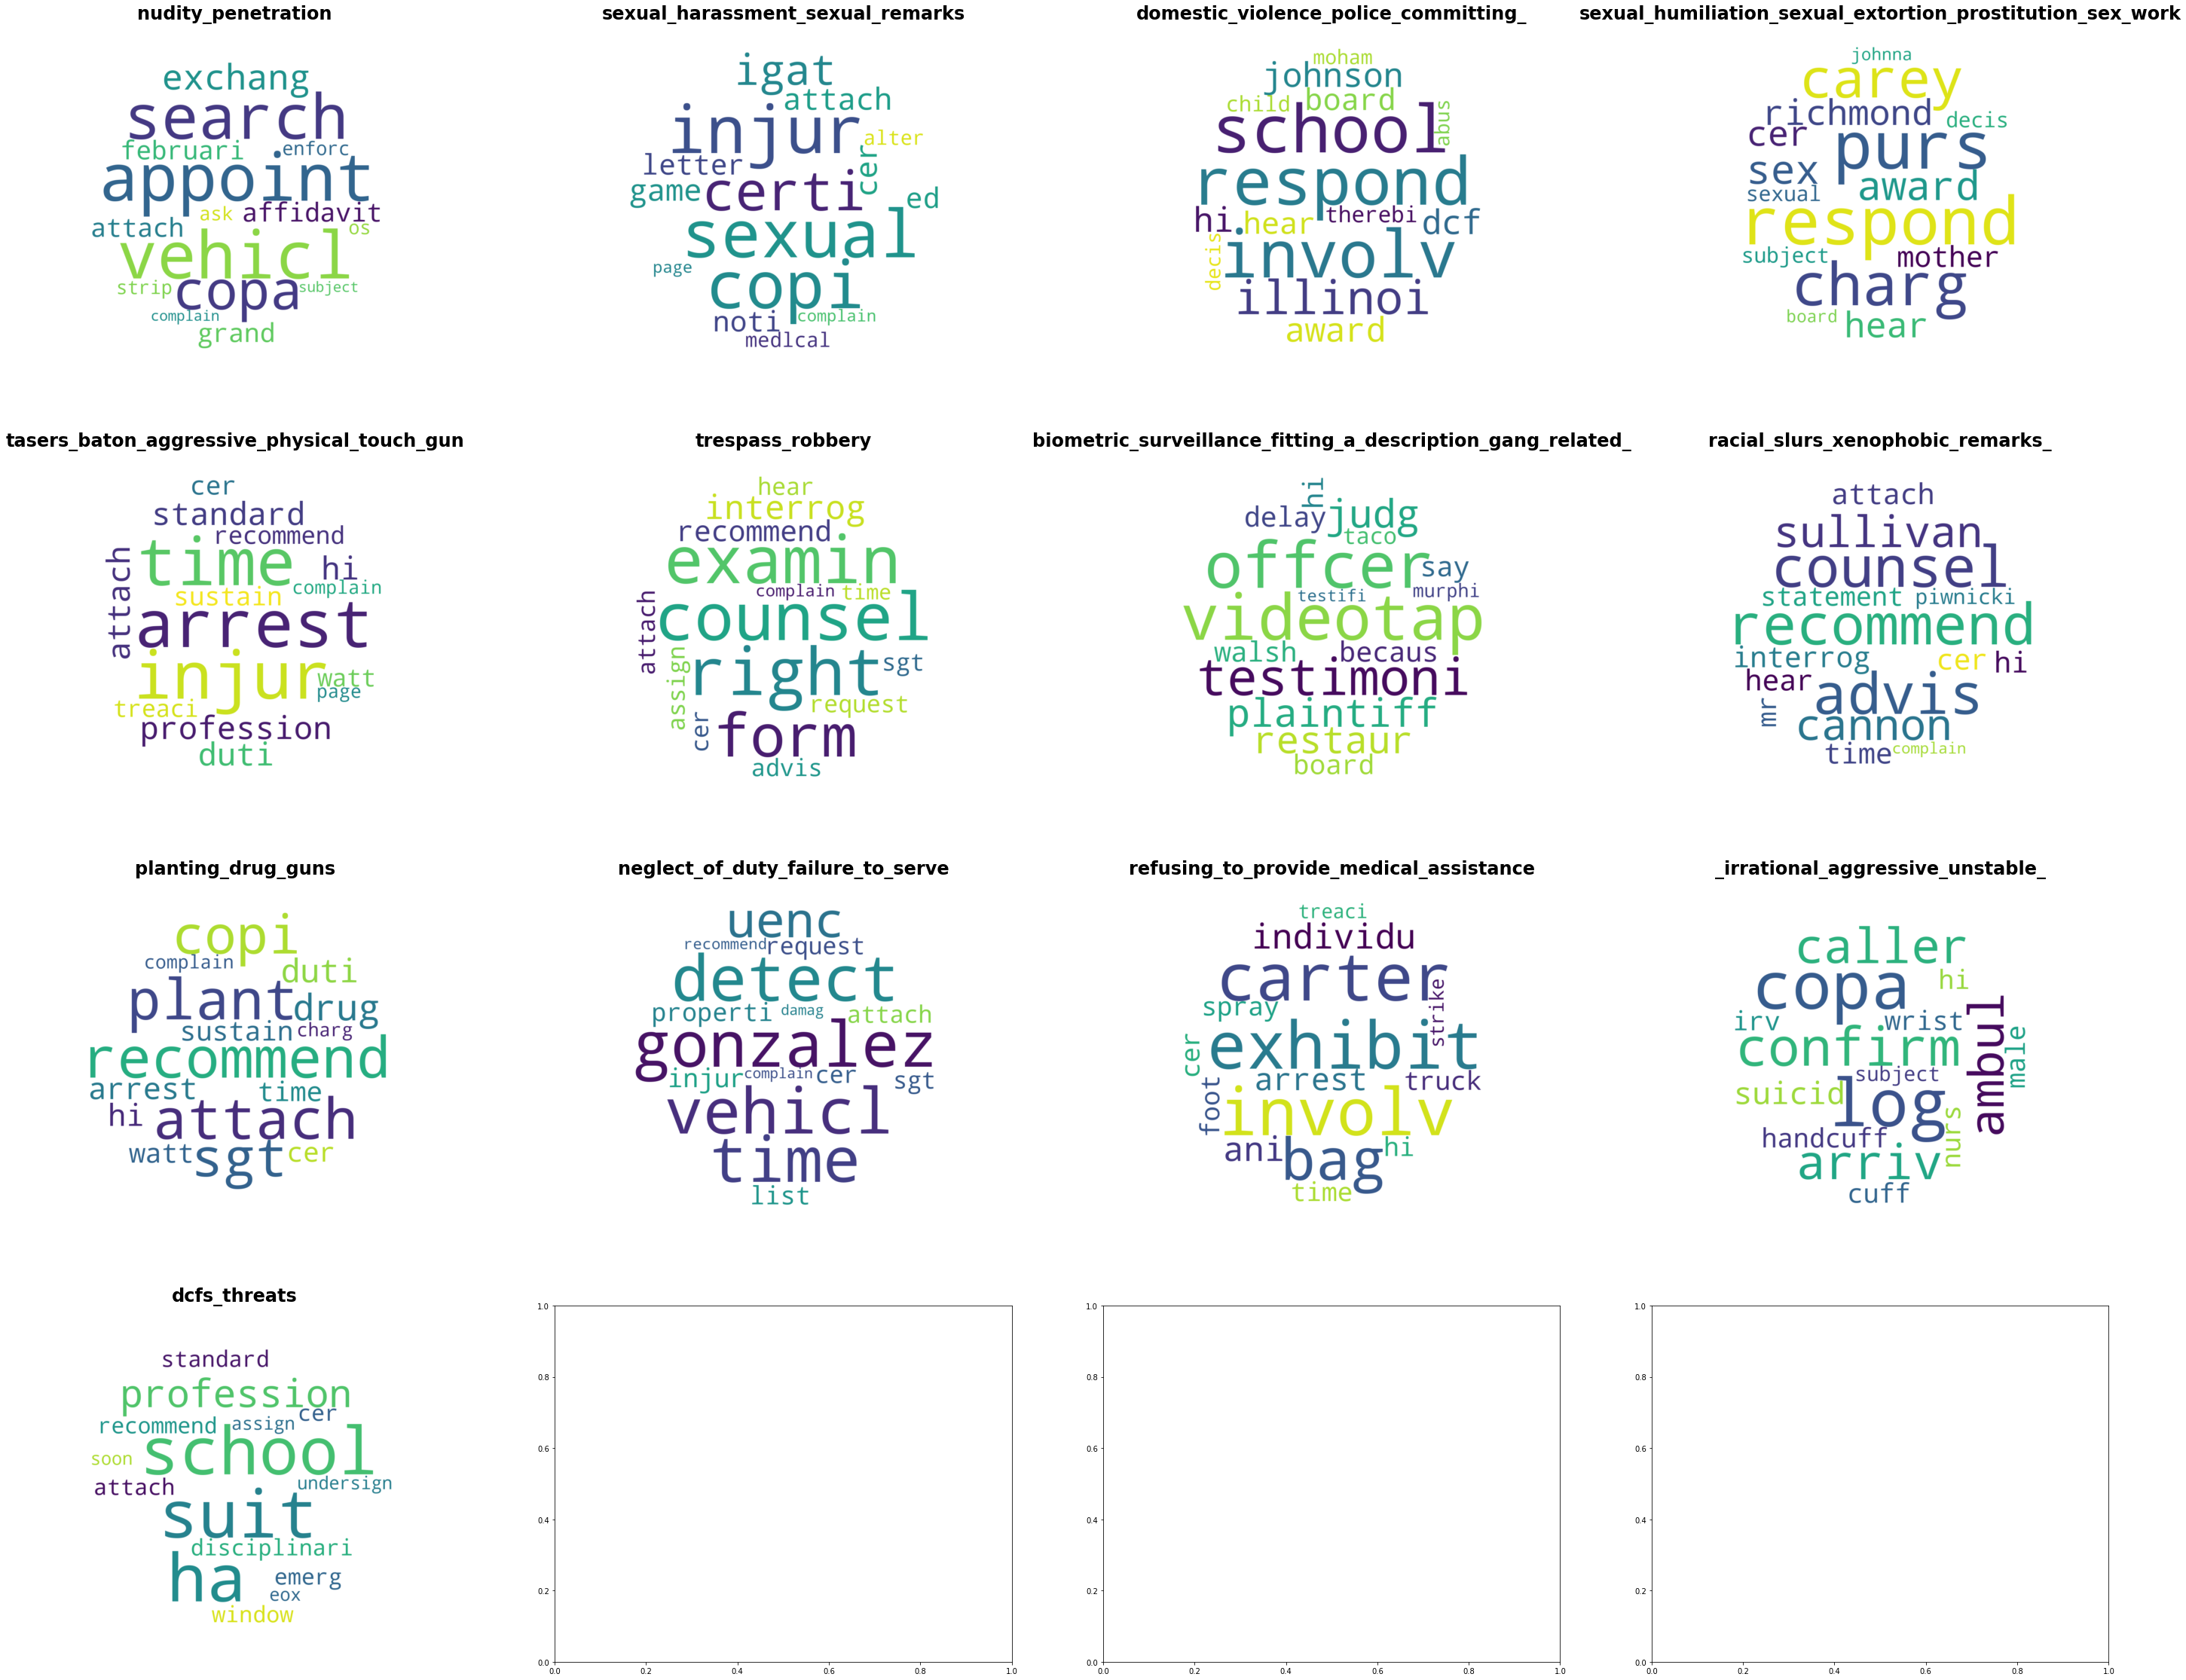

In [0]:
show_topK(nb_clf, vectorizer, category_names, K=15) # keywords for each class by original NB classifier

nudity_penetration: exchang os attach affidavit grand ask enforc copa vehicl appoint complain februari search strip subject
sexual_harassment_sexual_remarks: letter ed alter copi igat medlcal injur game sexual noti attach certi page cer complain
domestic_violence_police_committing_: fals child charg dcf oral hi guilti johnson hear decis respond award board involv moham
sexual_humiliation_sexual_extortion_prostitution_sex_work: subject mother purs sex charg sexual decis richmond respond cer johnna hear carey award board
tasers_baton_aggressive_physical_touch_gun: watt subject duti piwnicki time injur profession arrest complain standard attach recommend sustain hi cer
trespass_robbery: sustain assign right form request cer examin interrog advis recommend time counsel sgt complain attach
biometric_surveillance_fitting_a_description_gang_related_: restaur judg becaus taco offcer say hi videotap walsh delay testifi plaintiff testimoni murphi board
racial_slurs_xenophobic_remarks_: attach co

IndexError: ignored

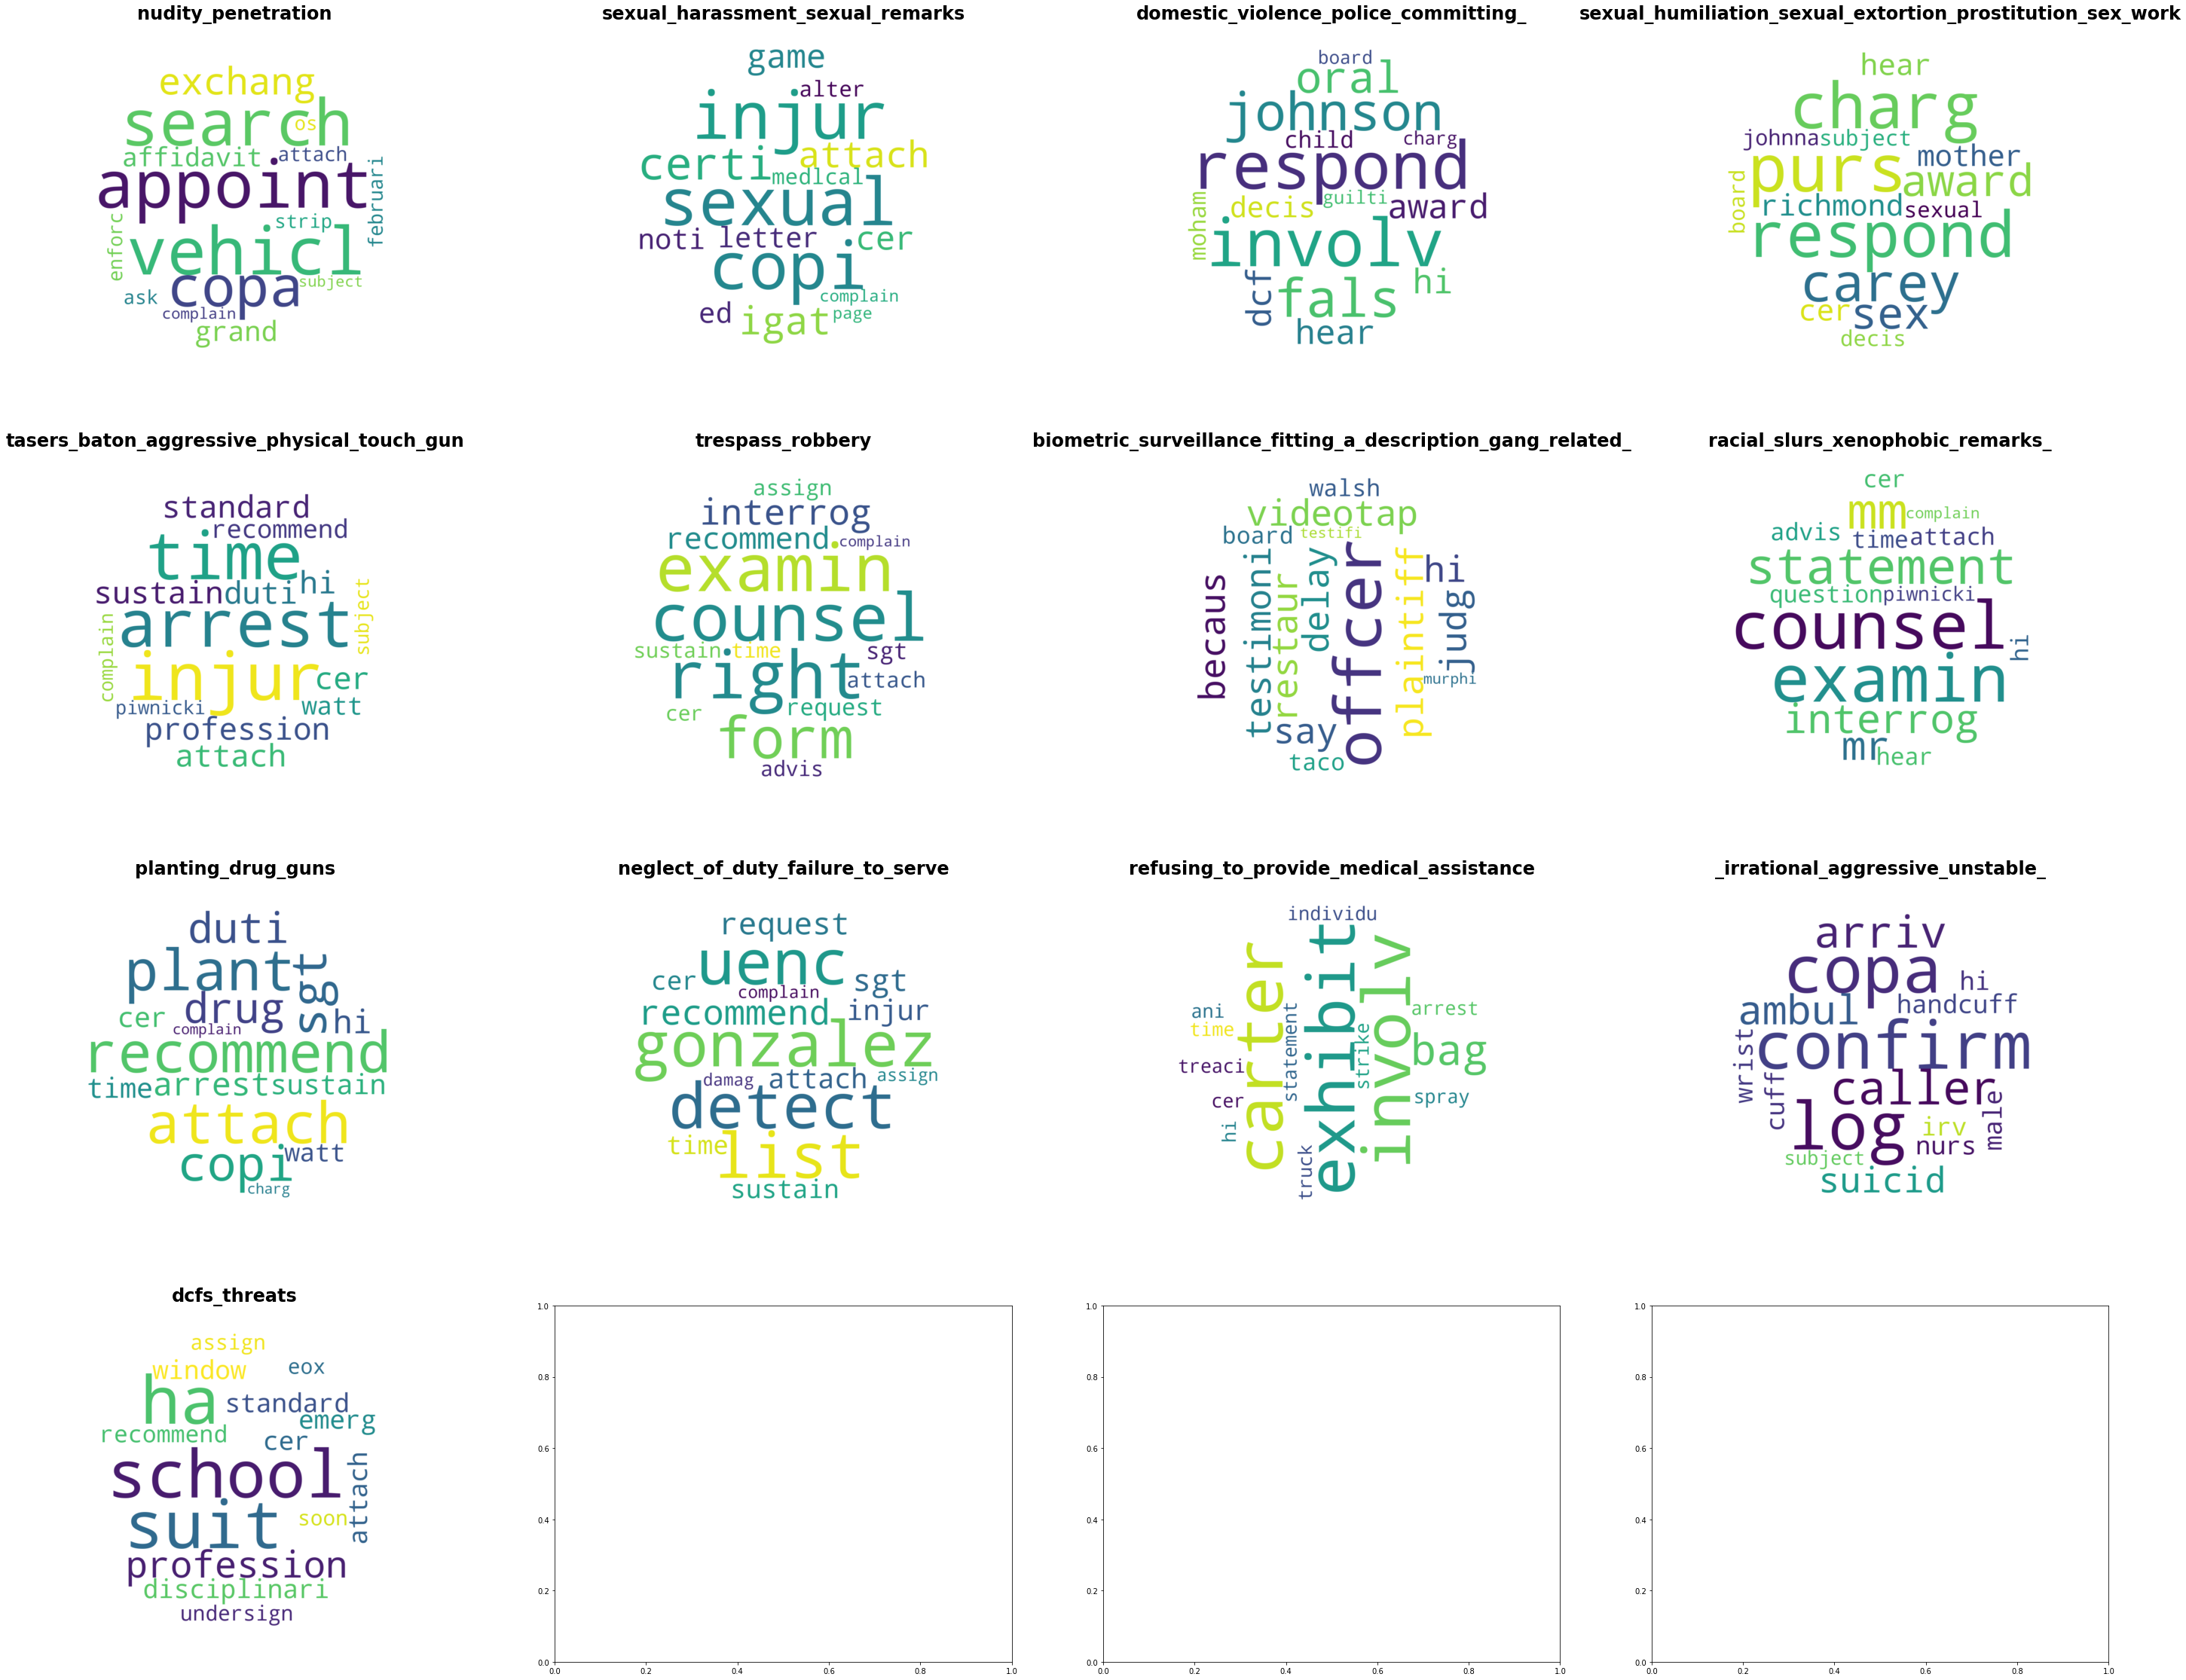

In [0]:
show_topK(em_nb_clf, vectorizer, category_names, K=15) # keywords for each class by semisupervised EM NB classifier